# **Introduction**

In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained PyTorch RetinaNet Object Detection For Inference on Test Images.


### **Setting up Colab :**

In [1]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [2]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall --yes torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

     |████████████████████████████████| 510 kB 20.3 MB/s 
     |████████████████████████████████| 79 kB 2.9 MB/s 
     |████████████████████████████████| 829 kB 59.3 MB/s 
     |████████████████████████████████| 117 kB 45.7 MB/s 
Found existing installation: torchtext 0.13.1
Uninstalling torchtext-0.13.1:
  Successfully uninstalled torchtext-0.13.1
Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 2137, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 2137 (delta 56), reused 32 (delta 15), pack-reused 2032
Receiving objects: 100% (2137/2137), 84.65 MiB | 23.47 MiB/s, done.
Resolving deltas: 100% (1406/1406), done.


In [3]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[BCCD Dataset](https://public.roboflow.com/object-detection/bccd)** from RoboFlow. There are 364 images across three classes.


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [4]:
!pip uninstall --yes opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 201 kB/s 


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vIGmJCuUiedzduuSj21T")
project = rf.workspace("molonyez55-wnf26").project("melony")
dataset = project.version(27).download("voc")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 36.8 MB/s 
     |████████████████████████████████| 178 kB 59.3 MB/s 
     |████████████████████████████████| 1.1 MB 61.7 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 138 kB 78.3 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.14-py3-none-any.whl size=24837 sha256=138dafec9e8508245002b7cebc29196df7dda6ed00a3e41d5451b5c046255c54
  Stored in directory: /root/.cache/pip/wheels/c7/84/36/a6a32c749ead923690d15d20443fb53fa2fe10beaa408f371b
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=bb6af1187eb911b2aef79700441c939ca4701d081e42b886724fa7ea3c31baa5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Melony-27 in voc:: 100%|██████████| 2337/2337 [00:00<00:00, 2981.54it/s]


In [6]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/Melony-27/train"
VALID_IMAGE_PATH = "/content/Melony-27/valid/"
TEST_IMAGE_PATH  = "/content/Melony-27/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/Melony-27/train/"
VALID_ANNOT_PATH = "/content/Melony-27/valid/"
TEST_ANNOT_PATH  = "/content/Melony-27/test/"

In [7]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [8]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **CSV Files are as follows :**

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/Melony-27/train/IMG_20220222_104927_jpg.rf.bfa8b119c85b255c570e61366c2734cd.jpg,416,416,Downy Mildew,90,126,342,311,1
1,/content/Melony-27/train/IMG_20220222_102816_jpg.rf.3eb465c5f96aec8e5473e9c79270e232.jpg,416,416,Powdery Mildew,78,66,377,339,2
2,/content/Melony-27/train/IMG_20220222_093517_jpg.rf.404afae1fb03c5e05cfa402006649eca.jpg,416,416,Downy Mildew,42,152,332,406,1
3,/content/Melony-27/train/IMG_20220222_104036_jpg.rf.84b3c2855bd70439ba8bbde496d3052e.jpg,416,416,Powdery Mildew,5,61,417,363,2
4,/content/Melony-27/train/IMG_20220222_092556_jpg.rf.ac199a983257f9f6a578982aafa7a479.jpg,416,416,Downy Mildew,11,86,366,340,1


In [ ]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/Melony-27/valid/IMG_20220222_104608_jpg.rf.1ecfbd62a1304a147b0f381a90244481.jpg,416,416,Powdery Mildew,12,149,327,361,2
1,/content/Melony-27/valid/IMG_20220222_103456_jpg.rf.8ec9a923837ca8ca73a5d7639221e39b.jpg,416,416,Downy Mildew,78,79,307,272,1
2,/content/Melony-27/valid/IMG_20220222_103845_jpg.rf.9850c0f0e5ce31604b964634f16fd469.jpg,416,416,Downy Mildew,22,95,386,357,1
3,/content/Melony-27/valid/IMG_20220222_103845_jpg.rf.9850c0f0e5ce31604b964634f16fd469.jpg,416,416,Downy Mildew,209,1,408,109,1
4,/content/Melony-27/valid/IMG_20220222_104642_jpg.rf.5ba7a62a54fd1baaeee90799fceeba2f.jpg,416,416,Downy Mildew,1,116,417,367,1


In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/Melony-27/test/IMG_20220222_104924_jpg.rf.4a123b17472c09b26e755f940b830425.jpg,416,416,Downy Mildew,66,142,353,387,1
1,/content/Melony-27/test/1645550057115_jpg.rf.c54248f1028639730e0d5f35a9e123c6.jpg,416,416,Downy Mildew,93,176,340,375,1
2,/content/Melony-27/test/IMG_4515_jpg.rf.17869ff12cd62c8bc6b08984d03ec578.jpg,416,416,Downy Mildew,5,64,343,335,1
3,/content/Melony-27/test/IMG_4549_jpg.rf.e0f7c4656736accf3ce327e39174b24f.jpg,416,416,Powdery Mildew,89,47,377,331,2
4,/content/Melony-27/test/IMG_20220222_090307_jpg.rf.653417d0c3c507cce3d76bfcfabcd147.jpg,416,416,Powdery Mildew,38,88,358,316,2


In [9]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/Melony-27/train/train_data.csv"
VALID_CSV = "/content/Melony-27/valid/valid_data.csv"
TEST_CSV  = "/content/Melony-27/test/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [10]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

In [ ]:
%cd /content/Melony-27/train/
%cp /content/Melony-27/train/train_data.csv /content/Melony-27/
%cp /content/Melony-27/test/test_data.csv /content/Melony-27/
%cp /content/Melony-27/valid/valid_data.csv /content/Melony-27/

/content/Melony-27/train


# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [11]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'Downy Mildew', 'Powdery Mildew']

##**Plot images with Bounding boxes over them**:

In [12]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.  
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

### **Image from Train Data:**

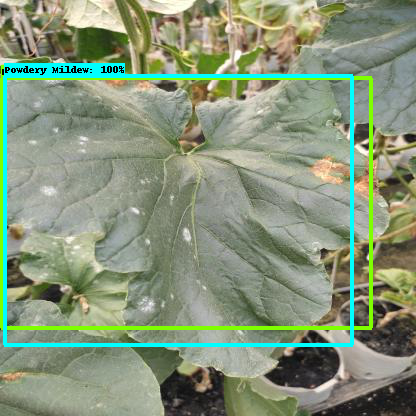

In [ ]:
image = load_image_from_data(train_df, index=10)
image

### **Image from Validation data:**

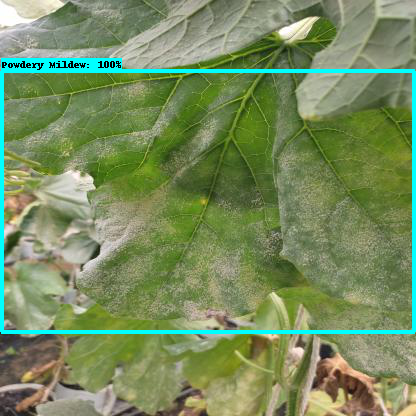

In [ ]:
image = load_image_from_data(valid_df, index=10)
image

###**Image from Test Data:**

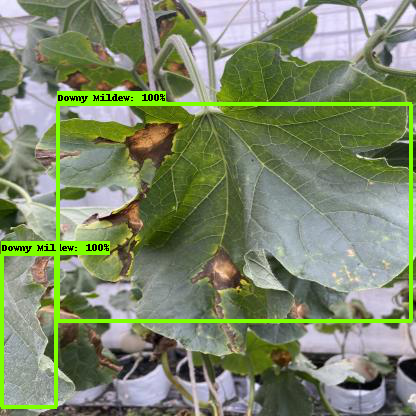

In [ ]:
image = load_image_from_data(test_df, index=5)
image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :

The configuration file is present in `/content/pytorch_retinanet/hparams.yaml`.


In [13]:
NUM_TRAIN_EPOCHS = 50


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

#hparams.dataloader.train_bs = 1
hparams.dataloader.train_bs = 16
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP) - 1 
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR", 
    "params"     : {"T_max": NUM_TRAIN_EPOCHS}, 
    "monitor"    : None, 
    "interval"   : "epoch", 
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 2
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/Melony-27/train/train_data.csv
  valid_paths: /content/Melony-27/valid/valid_data.csv
  test_paths: /content/Melony-27/test/test_data.csv
dataloader:
  train_bs: 16
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 50
  monitor: null
  interval: epoch
  frequency: 1



#**Instantiate Lightning-Module and Lightning-Trainer**

In [15]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from model import RetinaNetModel
#from torch.hub import load_state_dict_from_url
# seed so that results are reproducible
pl.seed_everything(123)

123

## **Load in the Lighning-Trainer :**

In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)
#gpus = 1 ของเดิม

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


##**Load in the Lighning-Module using the hparams file modified above & Start Train :**

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 2
INFO:retinanet.models:NUM_CLASSES  : 2


In [ ]:
import time
start = time.time()
trainer.fit(litModel)
stop = time.time()
print("The time of the run:", stop - start ,"seconds")
"""my added block
bbox=list(bbox)
for i in range(4):
  if (bbox[i]<0) :
    bbox[i]=0
  elif (bbox[i]>1) :
    bbox[i]=1
bbox=tuple(bbox)
end of block"""


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  
INFO:retinanet.models:
  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

The time of the run: 3290.2338428497314 seconds


'my added block\nbbox=list(bbox)\nfor i in range(4):\n  if (bbox[i]<0) :\n    bbox[i]=0\n  elif (bbox[i]>1) :\n    bbox[i]=1\nbbox=tuple(bbox)\nend of block'

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
trainer.test(litModel)

creating index...
index created!


Testing: 0it [00:00, ?it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

[{'AP': 0.11587982230286559}]

# **Export the model weights** :

In [ ]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
import logging
logger = logging.getLogger("lightning")

In [ ]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 2
INFO:retinanet.models:NUM_CLASSES  : 2


# **Run Inference on Test Images with Custom PyTorch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on 
        the given image. 
        Keys of the dictionary: 
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions
    
    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.
    
    Params
    ------ 
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

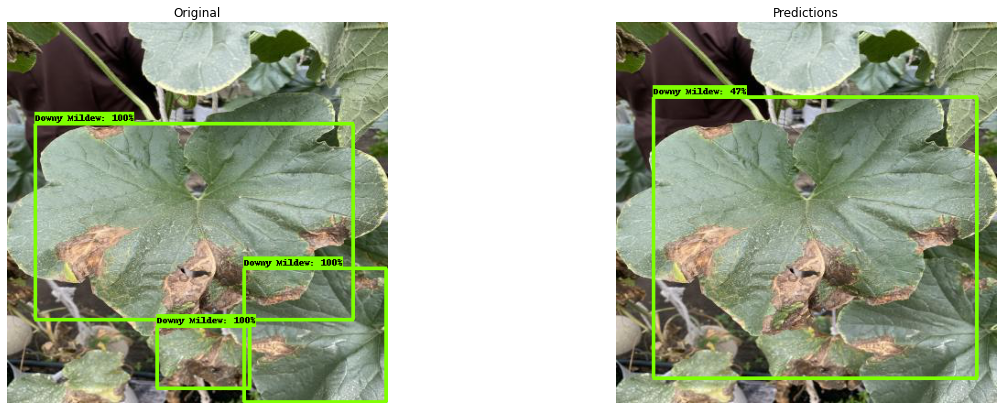

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.40)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

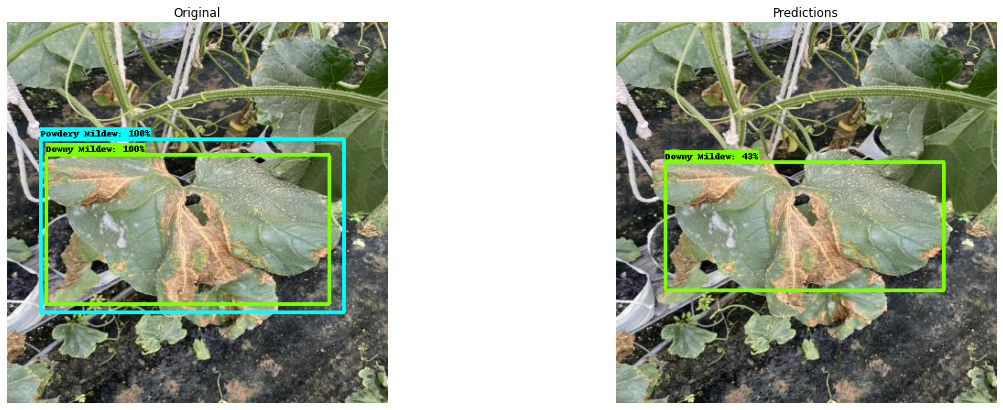

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.40)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");